# Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import shutil
import wandb
import matplotlib.pyplot as plt

from wandb.keras import WandbMetricsLogger, WandbCallback

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

from keras import backend as K



# Loading the AVA dataset

## Normalize scores with range 1-5, get the MOS, save new CSV

In [2]:
# data_mos.to_csv('/media/workstation/BackupDrive/Dataset/AVA/AVA_MOS.csv')
ava_directory = '/media/workstation/BackupDrive/Dataset/AVA/'
img_dir = ava_directory + 'data_512x/'
data_mos = pd.read_csv('/media/workstation/BackupDrive/Dataset/multimodel_dataset/ava_multimodel.csv', index_col='Index')

data_mos

,dataset,ID,1,2,3,4,5,6,7,8,9,10,sem1,sem2,challegeID,sum_score,total_scorer,MOS,scaled_MOS_aesthetic,set
Index,,,,,,,,,,,,,,,,,,,,
19640,ava,282007.jpg,0,4,3,19,45,113,100,80,49,34,14,43,430,3117,447,6.973154,4.041765,training
188121,ava,328576.jpg,1,1,4,20,58,60,45,27,8,11,6,20,487,1458,235,6.204255,3.588873,validation
28446,ava,738109.jpg,0,1,8,32,55,65,32,15,3,6,18,38,947,1250,217,5.760369,3.327418,training
135495,ava,155485.jpg,1,4,12,34,82,44,21,8,7,2,20,21,317,1149,215,5.344186,3.082280,training
74277,ava,356240.jpg,2,3,11,44,83,31,12,2,0,2,15,38,516,938,190,4.936842,2.842349,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11994,ava,903175.jpg,1,2,8,19,40,44,15,12,1,3,2,20,1254,809,145,5.579310,3.220772,training
201987,ava,271104.jpg,6,5,29,61,79,56,19,5,6,1,19,0,423,1315,267,4.925094,2.835429,training
87038,ava,716496.jpg,0,3,5,34,66,35,4,2,2,1,2,14,901,769,152,5.059211,2.914426,training


### Split images into train-validation-test directories 

In [3]:
data_mos_test = data_mos[data_mos['set'] == 'test']
display(data_mos_test)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_mos_test, 
    directory=img_dir, 
    x_col="ID", 
    y_col="scaled_MOS_aesthetic", 
    shuffle=False,
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=1
)

,dataset,ID,1,2,3,4,5,6,7,8,9,10,sem1,sem2,challegeID,sum_score,total_scorer,MOS,scaled_MOS_aesthetic,set
Index,,,,,,,,,,,,,,,,,,,,
74277,ava,356240.jpg,2,3,11,44,83,31,12,2,0,2,15,38,516,938,190,4.936842,2.842349,test
169040,ava,843742.jpg,0,5,6,27,54,37,3,0,1,0,18,0,1147,658,133,4.947368,2.848549,test
9958,ava,758263.jpg,1,1,3,11,38,61,59,48,20,7,14,21,982,1659,249,6.662651,3.858874,test
250960,ava,409454.jpg,85,41,48,54,26,7,2,1,0,0,15,38,568,721,264,2.731061,1.543113,test
21775,ava,847313.jpg,2,6,14,20,62,87,47,9,2,1,13,17,1154,1397,250,5.588000,3.225890,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10518,ava,178518.jpg,1,9,15,31,91,83,66,19,10,11,38,40,341,1955,336,5.818452,3.361630,test
129653,ava,173159.jpg,37,44,98,99,45,11,2,4,3,0,1,2,335,1179,343,3.437318,1.959108,test
104971,ava,14885.jpg,1,13,25,31,60,39,21,7,1,1,5,19,77,982,199,4.934673,2.841072,test


Found 2015 validated image filenames.


# Model Prediction (InceptionResNetV2)

## wandb configs

### Create the PLCC custom metric first

In [4]:
def plcc_tf(x, y):
    """PLCC metric"""
    xc = x - K.mean(x)
    yc = y - K.mean(y)
    return K.mean(xc*yc)/(K.std(x)*K.std(y) + K.epsilon())

def pearson_correlation(y_true, y_pred):
    # Subtract the mean from true and predicted values
    y_true_mean = K.mean(y_true)
    y_pred_mean = K.mean(y_pred)
    y_true_centered = y_true - y_true_mean
    y_pred_centered = y_pred - y_pred_mean

    # Calculate covariance and standard deviation
    covariance = K.mean(y_true_centered * y_pred_centered)
    y_true_std = K.std(y_true)
    y_pred_std = K.std(y_pred)

    # Calculate Pearson correlation coefficient
    pearson_coefficient = covariance / (y_true_std * y_pred_std + K.epsilon())

    return pearson_coefficient

In [5]:
class CustomMetricCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Calculate the custom metric
        y_true = self.validation_data[1]
        y_pred = self.model.predict(self.validation_data[0])
        pearson_coefficient = pearson_correlation(y_true, y_pred)

        # Log the custom metric using wandb
        wandb.log({"val_pearson_coefficient": pearson_coefficient})

In [6]:
# track hyperparameters 
config={
    "fc1" : 2048,
    "activation1" : 'relu',
    "dropout1": 0.25,
    "fc2" : 1024,
    "activation2" : 'relu',
    "dropout2": 0.25,
    "fc3" : 256,
    "activation3" : 'relu',
    "dropout3": 0.5,
    "fc4" : 1,
    "activation4" : 'linear',
    "dropout4": 0,
    "learning_rate" : 0.001,
    "optimizer": "adam",
    "loss": "mean_squared_error",
    "metric": "root_mean_squared_error",
    "epoch": 35,
    "batch_size": 1
}

In [7]:
# Load the InceptionResNetV2 model without pre-trained weights
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add your own top layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(config['fc1'], activation=config['activation1'])(x)
x = BatchNormalization()(x)
x = Dropout(config['dropout1'])(x)

x = Dense(config['fc2'], activation=config['activation2'])(x)
x = BatchNormalization()(x)
x = Dropout(config['dropout2'])(x)

x = Dense(config['fc3'], activation=config['activation3'])(x)
x = BatchNormalization()(x)
x = Dropout(config['dropout3'])(x)

predictions = Dense(config['fc4'], activation=config['activation4'])(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

optimizer = keras.optimizers.Adam(learning_rate=config['learning_rate'])

# Compile the model
model.compile(optimizer=optimizer,
              loss=config['loss'],
              metrics=[tf.keras.metrics.RootMeanSquaredError(), pearson_correlation]
              )

model.load_weights('/media/workstation/BackupDrive/model/baseline_ava_aesthetic_eternal_resonance_8/baseline_ava_aesthetic_weights_eternal_resonance_8.h5')



2023-07-08 22:53:21.669279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-08 22:53:21.674495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-08 22:53:21.674664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-08 22:53:21.675650: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
# Predict the model on the preprocessed test data
prediction = model.predict(
    test_generator,
    steps=len(test_generator)
)

2023-07-08 22:53:41.913696: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


In [9]:
import scipy 
from sklearn.metrics import mean_squared_error

def plcc(x, y):
    '''Pearson Linear Correlation Coefficient'''
    x, y = np.float32(x), np.float32(y)
    return scipy.stats.pearsonr(x,y)[0]

def srocc(xs, ys):
    '''Spearman Rank Order Correlation Coefficient'''
    correlation, p_value = scipy.stats.spearmanr(xs, ys)
    return correlation

def rmse(y_test, y_pred):
    mse = np.mean((y_test - y_pred) ** 2)
    return np.sqrt(mse)
    

SRCC/PLCC/RMSE 0.411/0.456/0.429


Text(0.5, 0.98, 'Quality Score Ground truth - Prediction')

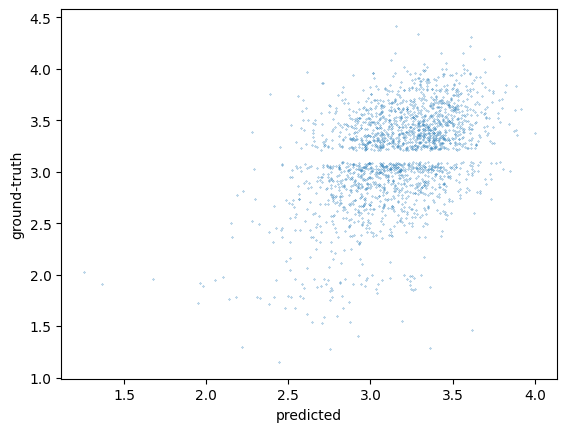

<Figure size 640x480 with 0 Axes>

In [11]:
# prediction
test_list = prediction.tolist()
test_list = [val[0] for val in test_list]
len(test_list)

# data_mos_test
test_1 = data_mos_test.copy()
test_1['pred_value'] = test_list
test_1

y_test = np.array(test_1.loc[:, 'scaled_MOS_aesthetic'])
y_pred = np.array(test_1.loc[:, 'pred_value'])

SRCC_test = round(srocc(y_pred, y_test), 3)
PLCC_test = round(plcc(y_pred, y_test), 3)
rmse_test = round(rmse(y_test, y_pred), 3)
print('SRCC/PLCC/RMSE {}/{}/{}'.format(SRCC_test, PLCC_test, rmse_test))

plt.plot(y_pred, y_test, '.', markersize=0.5)
plt.xlabel('predicted'); plt.ylabel('ground-truth'); plt.show
fig = plt.figure()
fig.suptitle('Quality Score Ground truth - Prediction')

In [39]:
test_1.to_csv('prediction_baseline_ava_aesthetic_eternal_resonance_8.csv')